# FWI on field data (CGG Broadseis)

by Oleg Ovcharenko

oleg.ovcharenko@kaust.edu.sa

KAUST, 2021

In [1]:
import os
import sys
#api._cmd('conda activate torch2')
print(f'Python: {sys.prefix}')
import copy
from glob import glob
# import glob
import numpy as np
import importlib
import multiprocessing
import segyio
from scipy import signal, ndimage
from natsort import natsorted
from skimage.transform import rescale, resize
from utils import shared as sd
from utils import loaders as ld
from utils import vis
from IPython.display import clear_output
# append path with actual source files to sys.path
sys.path.append(os.path.abspath('../codes_server'))
sys.path.append(os.path.abspath('./utils'))
from F_utils import *
from F_fwi import *
import pyapi_denise_pavel as api
api._cmd('source /home/plotnips/Madagascar/share/madagascar/etc/env.sh')
api._cmd('source ~/.bashrc')
# create_sbatch_file_for_fwi_folder('./for_pasha/out_for_pasha/fwi_full_spectrum_vanilla')
# results_path='./out_for_pasha/fwi_full_spectrum'
# os.system(f"rm -r {results_path}")
print(filter_seismic_data)
d=api.Denise('/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master',verbose=1)
print(d.get_shots_from_datadir)
print(d.get_shots_from_directory)
print(sys.path)

Python: /home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/for_pasha/env
<function filter_seismic_data at 0x1495c298e7b8>
Init Python 3 API for Denise-Black-Edition.
Check binary in /home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/bin/denise
Parse /home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/par/DENISE_marm_OBC.inp
Current directory is /home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/for_pasha
Init paths at ./outputs/
<bound method Denise.get_shots_from_datadir of DENISE-Black-Edition:
	/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master
Save folder:
	./outputs/
Run .help() for more details>
<bound method Denise.get_shots_from_directory of DENISE-Black-Edition:
	/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master
Save folder:
	./outputs/
Run .help() for more details>
['', '/home/plotnips/Madagascar/lib/python3.7/site-package

In [2]:
calculate_water_taper

<function F_utils.calculate_water_taper(generated_model, min_water_velocity=1490.001)>

In [3]:
# # This is to prevent error "this loop already runnign when doing magical %run <<notebook name>>"
import nest_asyncio
nest_asyncio.apply()

In [4]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
# mpl.rcParams['figure.dpi']= 100
fontsize = 10
params = {
    # 'text.latex.preamble': ['\\usepackage{gensymb}'],
    # 'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'figure.dpi' : 300,
    # 'image.cmap': 'gray',
    'axes.grid': False,
    'savefig.dpi': 150,  # to adjust notebook inline plot size
    'axes.labelsize':fontsize,  # fontsize for x and y labels (was 10)
    'axes.titlesize':fontsize,
    'font.size':fontsize,  # was 10
    'legend.fontsize': fontsize,  # was 10
    'xtick.labelsize':fontsize,
    'ytick.labelsize':fontsize,
    # 'text.usetex': True,
    # 'figure.figsize': [3.39, 2.10],
    'font.family': 'serif',
}
mpl.rcParams.update(params)

In [5]:
root_fwi = './out_for_pasha/'

# Init Denise API

In [6]:
denise_root = '../'
d = api.Denise(denise_root, verbose=1)

Init Python 3 API for Denise-Black-Edition.
Check binary in ../bin/denise
Parse ../par/DENISE_marm_OBC.inp
Current directory is /home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/for_pasha
Init paths at ./outputs/


## Work directory
Where to output everything

In [7]:
d.save_folder = root_fwi
d.set_paths()

Current directory is /home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/for_pasha
Init paths at ./out_for_pasha/


# Get acquitision details

In [8]:
shot_id_min = 60
n_selected_shots = 80
njump_src = 8
shot_id_max = shot_id_min + (n_selected_shots-1) * njump_src

95/95
Before prep:	(95, 648, 3526)
Data cube:	(95, 324, 3000)
Extended cube:	(95, 324, 3100)
[95, 324, 3050] (95, 324, 3000)
[95, 324, 3150] (95, 324, 3100)
25.0
Assume even average spacing between sources
 150.0 m ~ 6 grid nodes
First source:	375.0 m
Last source:	14450.0 m
150.0
name:	
x	(95,):	min: 375.0	max: 14475.0
y	(95,):	min: 50.0	max: 50.0
wavelets:	None
z	(95,):	min: 0.0	max: 0.0
nshot:	95
td	(95,):	min: 0.0	max: 0.0
fc	(95,):	min: 8.0	max: 8.0
amp	(95,):	min: 1.0	max: 1.0
angle	(95,):	min: 0.0	max: 0.0
QUELLTYPB:	1
src_type	(95,):	min: 1.0	max: 1.0
drec:	25.0 m
x	(324,):	min: 525.0	max: 8600.0
y	(324,):	min: 100.0	max: 100.0
many:	[x	(324,):	min: 525.0	max: 8600.0
y	(324,):	min: 100.0	max: 100.0
name:	]
x	(324,):	min: 525.0	max: 8600.0
y	(324,):	min: 100.0	max: 100.0
many:	[x	(324,):	min: 525.0	max: 8600.0
y	(324,):	min: 100.0	max: 100.0
name:	]
(152, 600)
(152, 600)
(152, 500)
12500.0


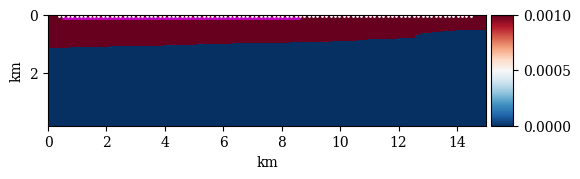

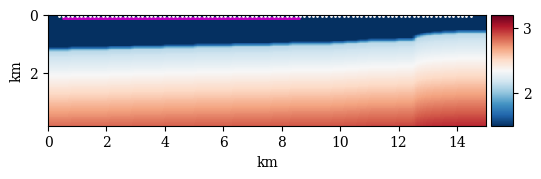

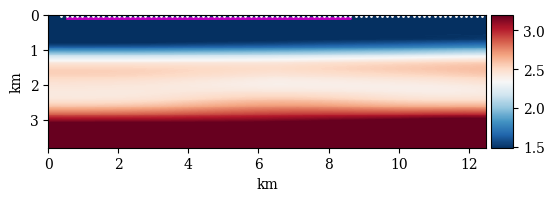

In [9]:
# %run ./fwi_shared_check.ipynb
%run ./fwi_shared_check_check_water_bottom.ipynb

In [10]:
print('Field data spacing between sources {:.2f} m'.format(np.mean(src_.x[1:] - src_.x[:-1])))

Field data spacing between sources 149.78 m


In [11]:
vp_baseline = vp.copy()
print(vp.shape)

marm_path = os.path.join(root_fwi, 'start/')
os.makedirs(marm_path, exist_ok=True)
print(marm_path)
if not 'marmousi_II_marine.vp' in os.listdir(marm_path):
    # Download Marmousi II model
    os.system(f'wget https://github.com/daniel-koehn/DENISE-Benchmark/raw/master/Marmousi-II/start/marmousi_II_marine.vp -P {marm_path}')
    os.system(f'wget https://github.com/daniel-koehn/DENISE-Benchmark/raw/master/Marmousi-II/start/marmousi_II_marine.vs -P {marm_path}')
    os.system(f'wget https://github.com/daniel-koehn/DENISE-Benchmark/raw/master/Marmousi-II/start/marmousi_II_marine.rho -P {marm_path}')

    # Download initial model for FWI
    os.system(f'wget https://github.com/daniel-koehn/DENISE-Benchmark/raw/master/Marmousi-II/start/marmousi_II_start_1D.vp -P {marm_path}')
    os.system(f'wget https://github.com/daniel-koehn/DENISE-Benchmark/raw/master/Marmousi-II/start/marmousi_II_start_1D.vs -P {marm_path}')
    os.system(f'wget https://github.com/daniel-koehn/DENISE-Benchmark/raw/master/Marmousi-II/start/marmousi_II_start_1D.rho -P {marm_path}')
    
def get_vp_vs_rho(vp):
    vp = extend(vp, 15, 0)

    print(f'Reshape {vp.shape} into {wb_taper.shape}...')

    vp = resize(vp, wb_taper.shape, anti_aliasing=True)
    vp = np.where(vp <= 1500.0, 1490.0, vp)
    vp = extend(vp, 0, 264 + 10 * 8)

    # shear velocity, [m/s]
    vs = vp.copy() / (3 ** 0.5)
    vs = np.where(vp < 1.01 * np.min(vp), 0, vs)

    # density, [kg/m3] 
    rho = 1e3*0.3 * vp.copy()**0.25
    rho = np.where(vp < 1.01 * np.min(vp), 1000, rho)
    return vp, vs, rho

(152, 600)
./out_for_pasha/start/


Extend the model so it accommodates full streamer length for the last shot

In [12]:
vp_long = extend(model.vp, 0, 264 + 10 * 8)
vp_cgg_tomo=vp_cgg
vp_cgg_tomo_long = extend(vp_cgg_tomo, 0, 364 + 10 * 8)
wb_taper2=extend(wb_taper, 0,264 + 10 * 8)
vp_cgg_tomo_long2=np.where(wb_taper2,1490.0,vp_cgg_tomo_long)
lin_vp_long=vp_long.copy()
# print(src)
# # print(rec)
# print(vp_baseline.shape)
print(model.vp.shape)
print(wb_taper.shape)
print(wb_taper2.shape)
print(vp_long.shape)
print(vp_cgg_tomo.shape)
print(vp_cgg_tomo_long.shape)
# vis.plot_acquisition(wb_taper,dx,src,rec)
# vis.plot_acquisition(wb_taper2,dx,src,rec)
# vis.plot_acquisition(vp_cgg_tomo_long, dx, src, rec, title='Vp',**{'vmax': 3.8, 'vmin': 1.5})
# vis.plot_acquisition(vp_cgg_tomo_long2, dx, src, rec, title='Vp',**{'vmax': 3.8, 'vmin': 1.5})
# vis.plot_acquisition(lin_vp_long, dx, src, rec, title='Vp',**{'vmax': 3.8, 'vmin': 1.5})

(152, 600)
(152, 600)
(152, 944)
(152, 944)
(152, 500)
(152, 944)


## Acquisition design

In [13]:
# Wavelet scaler to match field and synthetic
wavefield_amp_ratio = 77.08343437940496

In [14]:
print(1.01 * vp_cgg_tomo_long.min())
print(1.0 * vp_cgg_tomo_long.min())

1504.9
1490.0


(152, 600)
(152, 944)


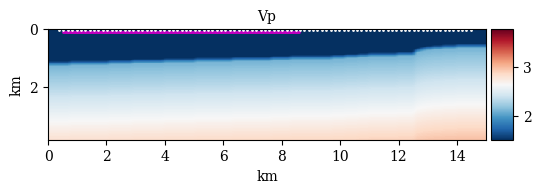

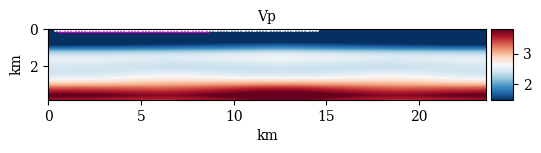

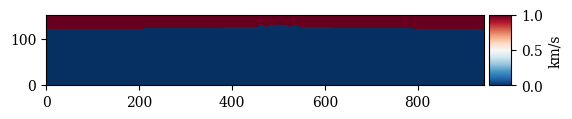

In [15]:
# Set custom wavelet
wls = bpw[:, ::2]
src.wavelets = wavefield_amp_ratio * wls[:, :limit_nt]
wb_taper = np.where(vp_cgg_tomo_long < 1.01 * vp_cgg_tomo_long.min(), 1, 0)
wb_taper3=calculate_water_taper(np.flipud(vp_cgg_tomo_long),min_water_velocity=1.01 * vp_cgg_tomo_long.min())
wb_taper3=np.flipud(wb_taper3)
# vis.plot_model(wb_taper3-wb_taper)
wb_taper=wb_taper3
vis.plot_acquisition(vp,dx,src,rec, title='Vp',**{'vmax': 3.8, 'vmin': 1.5})
vis.plot_acquisition(vp_cgg_tomo_long, dx, src, rec, title='Vp',**{'vmax': 3.8, 'vmin': 1.5})
vis.plot_model(wb_taper3)
# print(vp_cgg_tomo_long)
print(vp.shape)
print(vp_cgg_tomo_long.shape)

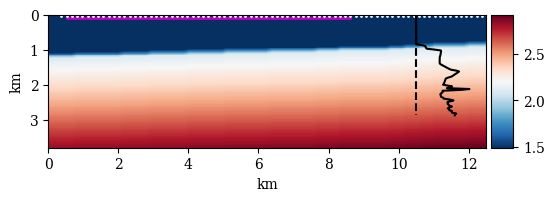

In [16]:
# log = model.vp[:, log_idx]
log = model.vp[-len(wlog):, log_idx]
# model_log = copy.deepcopy(model)
log_dict = {'data':wlog, 'loc': log_loc}
vis.plot_acquisition(vp[:, :500], dx, src, rec, log=log_dict)
# vis.savefig('vinit.png')

Create new initial (orange line). This is to see whether knowledge about exact waterbottom will improve results

In [17]:
new_vp = np.zeros_like(model.vp)
vps=[]
for i in range(wb_taper.shape[-1]):
    wb = wb_taper.shape[0] - np.argmax(wb_taper[:,i]) + 2
    fun = vmin * np.ones_like(new_vp[:, 0:1])
    fun[wb:, :] = 690 + fun[wb:, :] + 6 * np.expand_dims(np.arange(len(fun[wb:, 0])), 1)
    fun = fun[::-1, :]
    vps.append(fun)
new_vp = np.concatenate(vps, -1)
new_vp = gaussian_filter(new_vp.copy(), **sigma_truncate)

print(new_vp.shape)
print(f'Well-log from {log_loc} maps into ix: {log_idx}')
# plt.figure(); plt.plot(wlog, 'k--'); plt.plot(log[-len(wlog):]); plt.plot(new_vp[-len(wlog):, log_idx])

(152, 944)
Well-log from 10500 maps into ix: 420


Set new model as initial

In [18]:
vp = vp_cgg_tomo_long.copy()
# vp = new_vp.copy()
vs = vp.copy() / (3 ** 0.5)
rho = 1e3*0.3 * vp.copy()**0.25

vp = np.where(wb_taper, np.min(vp_cgg), vp)
vs = np.where(wb_taper, 0, vs)
rho = np.where(wb_taper, 1000, rho)

# log = vplog.copy()
model = api.Model(vp, vs, rho, dx)
print(src, end='\n\n------------\n')
print(rec)

name:	
x	(95,):	min: 375.0	max: 14475.0
y	(95,):	min: 50.0	max: 50.0
wavelets	(95, 3000):	min: -400.8610078720592	max: 484.6122728113698
z	(95,):	min: 0.0	max: 0.0
nshot:	95
td	(95,):	min: 0.0	max: 0.0
fc	(95,):	min: 8.0	max: 8.0
amp	(95,):	min: 1.0	max: 1.0
angle	(95,):	min: 0.0	max: 0.0
QUELLTYPB:	1
src_type	(95,):	min: 1.0	max: 1.0

------------
x	(324,):	min: 525.0	max: 8600.0
y	(324,):	min: 100.0	max: 100.0
many:	[x	(324,):	min: 525.0	max: 8600.0
y	(324,):	min: 100.0	max: 100.0
name:	]


In [19]:
print(bpw.shape)
bpw2=bpw[0:1,::2]
bpw2=bpw2[:,:3000]
print(bpw2.shape)
bpw2=src.wavelets[0:1,:]
print(bpw2.shape)

(95, 7052)
(1, 3000)
(1, 3000)


In [20]:
acq_data = {'src':src,'rec':rec,'wavelet':bpw2,'src_x0':src_x0,'rec_x0':rec_x0,'dsrc':dsrc,'drec':drec,'dDT':dDT,
           'log_dict':log_dict}
print(os.getcwd())
# with open(os.path.join('acq_data_parameters.pkl'),'rb') as input:
#     d2=pickle.load(input)
# print(d2)
print(src)
with open(os.path.join('acq_data_parameters_cgg_correct.pkl'), 'wb+') as output:
    pickle.dump(acq_data,output,protocol=4)
# with open(os.path.join('for_pasha','acq_data_parameters.pkl'), 'wb+') as output:
#     pickle.dump(acq_data,output,protocol=4)

/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/for_pasha
name:	
x	(95,):	min: 375.0	max: 14475.0
y	(95,):	min: 50.0	max: 50.0
wavelets	(95, 3000):	min: -400.8610078720592	max: 484.6122728113698
z	(95,):	min: 0.0	max: 0.0
nshot:	95
td	(95,):	min: 0.0	max: 0.0
fc	(95,):	min: 8.0	max: 8.0
amp	(95,):	min: 1.0	max: 1.0
angle	(95,):	min: 0.0	max: 0.0
QUELLTYPB:	1
src_type	(95,):	min: 1.0	max: 1.0


## Generate true waveforms

Set some runtime parameters which are different from defaults. Check defaults by runnning `help()`

In [21]:
# Elastic modeling
d.verbose = 1
d.PHYSICS = 1
d.DT = dDT
d.NT = data_p.shape[-1]
d.TIME = dDT * d.NT
#
d.FC_SPIKE_2 = 10
# DSCRC=5000;     
# dsrc=DSCRC
d.REC_INCR_X = dsrc
d.N_STREAMER = len(rec)
d.TESTSHOT_START = 1
d.TESTSHOT_END = len(src)
d.TESTSHOT_INCR = 10
d.QUELLTYPB = 4
d.QUELLART = 3  
d.WRITE_STF = 0
d.SEISMO = 2

# d.TESTSHOT_START = np.round(0.1 * len(src))
# d.TESTSHOT_END = np.round(0.9 * len(src))
# d.TESTSHOT_INCR = 5
print(d.DT, d.NT)

0.002 3000


### Run forward modeling

In [26]:
d.NPROCX = 1
d.NPROCY = 1
par_forward = {'run_command': 'mpirun -np 30', 'disable': False}
root_su_field = os.path.join(d._root_su, 'field/'); 
d.SEIS_FILE_P=root_su_field
print(d.SEIS_FILE_P)
print(root_fwi)

./out_for_pasha/su/field/
./out_for_pasha/


In [25]:
# d.forward(model, src, rec, **par_forward)
# d.save_folder = root_fwi

Init model:
	152 x 944, dx = 25.0 m
Check max source frequency:
	min Vs: 865.6191019897758 m/s
	min Vp: 1490.0 m/s
	Number of gridpoints per minimum wavelength = 3.69
	Maximum source wavelet frequency = 9.383404899618165 Hz
Check domain decomposition for parallelization:
	in X-direction, NX % NPROCX, 944 % 1 = 0
	in Y-direction, NY % NPROCY, 152 % 1 = 0
Write ./out_for_pasha/start/model.vp
Write ./out_for_pasha/start/model.vs
Write ./out_for_pasha/start/model.rho
Enable streamer mode!
	source 1: ./out_for_pasha/receiver/receivers_shot_1
	source 2: ./out_for_pasha/receiver/receivers_shot_2
	source 3: ./out_for_pasha/receiver/receivers_shot_3
	source 4: ./out_for_pasha/receiver/receivers_shot_4
	source 5: ./out_for_pasha/receiver/receivers_shot_5
	source 6: ./out_for_pasha/receiver/receivers_shot_6
	source 7: ./out_for_pasha/receiver/receivers_shot_7
	source 8: ./out_for_pasha/receiver/receivers_shot_8
	source 9: ./out_for_pasha/receiver/receivers_shot_9
	source 10: ./out_for_pasha/recei

	wavelet 47: ./out_for_pasha/wavelet/wavelet_shot_47.dat
	wavelet 48: ./out_for_pasha/wavelet/wavelet_shot_48.dat
	wavelet 49: ./out_for_pasha/wavelet/wavelet_shot_49.dat
	wavelet 50: ./out_for_pasha/wavelet/wavelet_shot_50.dat
	wavelet 51: ./out_for_pasha/wavelet/wavelet_shot_51.dat
	wavelet 52: ./out_for_pasha/wavelet/wavelet_shot_52.dat
	wavelet 53: ./out_for_pasha/wavelet/wavelet_shot_53.dat
	wavelet 54: ./out_for_pasha/wavelet/wavelet_shot_54.dat
	wavelet 55: ./out_for_pasha/wavelet/wavelet_shot_55.dat
	wavelet 56: ./out_for_pasha/wavelet/wavelet_shot_56.dat
	wavelet 57: ./out_for_pasha/wavelet/wavelet_shot_57.dat
	wavelet 58: ./out_for_pasha/wavelet/wavelet_shot_58.dat
	wavelet 59: ./out_for_pasha/wavelet/wavelet_shot_59.dat
	wavelet 60: ./out_for_pasha/wavelet/wavelet_shot_60.dat
	wavelet 61: ./out_for_pasha/wavelet/wavelet_shot_61.dat
	wavelet 62: ./out_for_pasha/wavelet/wavelet_shot_62.dat
	wavelet 63: ./out_for_pasha/wavelet/wavelet_shot_63.dat
	wavelet 64: ./out_for_pasha/wa

In [ ]:
d.verbose = 0    # don't show redundant print outs
if d.DT is None:
    d.DT = 0.002
print(d.DATA_DIR)
mpl.rcParams['figure.dpi']= 300
par_shot = {'vmin': -0.05, 'vmax': 0.05}
data_p_backup = data_p.copy()

# REPLACE FIELD DATA BY MARM DATA

In [ ]:
print(data_p_backup.shape, d.DT)
par_mutter = {'k': 7, 'b': -100, 'r': 30}
new_data_p = []
for idat in range(data_p.shape[0]):
    new_data_p.append(np.expand_dims(ld.mutter(data_p[idat, ...], **par_mutter), 0))
new_data_p = np.concatenate(new_data_p)
new_data_p.shape

In [ ]:
# vis.plot_shot(new_data_p[0,...], pclip=0.0125)
# vis.plot_shot(new_data_p[0,...])

In [ ]:
# vis.plot_spectrum2(data_p[0,...], pclip=0.5, title='', colorbar=False, dt=0.002, dx=dx, fmax=20, kmax=None,
#                    figsize=None, axis=True, plot_only=False)

In [ ]:
# par_mutter = {'k': 7, 'b': 100, 'r': 30}
# vis.plot_shot(ld.mutter(data_p[0,...], **par_mutter), pclip=0.0125)

In [ ]:
# # data_p = np.concatenate([np.expand_dims(s, 0) for s in shots], 0)
# print(data_p.shape, data_p.min(), data_p.max())
# dref = np.mean(data_p, 0)
# fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# vis.plot_shot(dref, title='Field data', pclip=0.25, colorbar=True, ax=ax[0])
# vis.plot_spectrum(dref, dt=0.002, fmax=10, title='Spectrum', ax=ax[1])

## Save field data to a new folder in /su/

In [ ]:
def copy_su_from_to(path_from, path_to):
    """ Copy files matching *.su.* from one folder to another folder"""
    os.makedirs(path_to, exist_ok=True)
    su_files = glob(path_from + '/*.su.*')
    su_files = [f for f in su_files if '.it' not in f]
    print(f'Found {len(su_files)} *.su.* files in {path_from}')

    commands = []
    print(f'Copy files from {path_from} to {path_to}')
    for f in su_files:
        commands.append(f'cp {f} {path_to}')
    with multiprocessing.Pool() as pool:
        pool.map(os.system, commands)

In [ ]:
from glob import glob
print(d._root_su)
print(root_su_field)
# copy_su_from_to(d._root_su,root_su_field)

In [ ]:
shots,filenames=d.get_shots_from_directory(d._root_su,keys=['_p'],return_filenames=True)
shots=shots[::20]
filenames=filenames[::20]
print(filenames)
for shot,filename in zip(shots,filenames):
    print(filename)
    plot_shot(shot,pclip=0.05,folder_path='./pictures_for_check',file_path=filename.split('/')[-1]+'.png',show=0)

# Write field data into created .su files

In [ ]:
def get_fnames_pattern(pattern):    
    fnames = natsorted(glob(pattern))
    fnames = [f for f in fnames if '.it' not in f]
    print(f'{len(fnames)} files found in {pattern}')
    return fnames
fnames = get_fnames_pattern(root_su_field + '*.su.*')
print(fnames)
for i, f in enumerate(fnames):
    with segyio.su.open(f, "r+", endian='little', ignore_geometry=True) as dst:
        tmp = new_data_p[i, :, ::d.NDT]
        dst.trace = tmp
        print(f, dst.tracecount, tmp.shape, end='\r')

In [ ]:
def filter_seismic_data(path,dt=0.002,corner_frequency=5,fmax=10):
    # d=api.Denise('./',verbose=1)
    d=api.Denise('/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master',verbose=0)
    shots,filenames=d.get_shots_from_directory(path,return_filenames=True)
    print('low frequency data corner frequency, ',corner_frequency)
    print(f'Read {len(shots)} shots {shots[0].shape} into list')
    counter=0
    for shot,filename in zip(shots,filenames):
        ################    processing stage 1
        filtered_shot=bandpass(shot,fhi=6, dt=dt,order=8, btype='low')
        ################    processing stage 2
        filtered_shot2=bandpass(shot,flo=corner_frequency+0.8,dt=dt,order=8,btype='high')
        filtered_shot2_=bandpass(shot,flo=corner_frequency+0.8,fhi=6,dt=dt,order=8,btype='band') #for plotting purposes
        ################    processing stage 3
        filtered_shot3=zero_below_freq(filtered_shot2,corner_frequency+0.1,dt, disable=False,reverse=False)
        filtered_shot3_=zero_below_freq(filtered_shot2_,corner_frequency+0.1,dt, disable=False,reverse=False)
        ################
        plotting_flag=1
        if plotting_flag==1:
            shots_list=[0,22,44,66]
            if counter in shots_list:
                plot_shot(shot,pclip=0.05,folder_path='./pictures_for_check',file_path='shot_'+str(counter)+'.png',show=0)
                plot_shot(filtered_shot2,pclip=0.05,folder_path='./pictures_for_check',file_path='shot'+str(counter)+'_stage2.png',show=0)
                freqs,ps=plot_spectrum(shot,dt,fmax=fmax,folder_path='./pictures_for_check',file_path='spectrum_'+str(counter)+'_original.png')
                freqs,ps=plot_spectrum(filtered_shot2,dt,fmax=fmax,folder_path='./pictures_for_check',file_path='spectrum_'+str(counter)+'stage2.png')
        ################    chosen processing    
        with segyio.su.open(filename,"r+",endian='little',ignore_geometry=True) as dst:
            dst.trace=filtered_shot2
        # shot_read,read_filename=d.get_shots_from_datadir(keys=[filename],return_filenames=True); shot_read=shot_read[0]
        counter=counter+1
    return None

print(os.getcwd())
print(d.DT)
su_field_path1 = os.path.join(os.getcwd(),'su_field_high_pass_5_hz/')
su_field_path2 = os.path.join(os.getcwd(),'su_field/')

api._cmd('rm -r '+su_field_path1)
copy_su_from_to(root_su_field,su_field_path1)
filter_seismic_data(su_field_path1,dt=0.002,corner_frequency=5,fmax=10)

api._cmd('rm -r '+su_field_path2)
copy_su_from_to(root_su_field,su_field_path2)

In [ ]:
shots,filenames=d.get_shots_from_directory(su_field_path2,keys=['_p'],return_filenames=True)
shots=shots[::10]
filenames=filenames[::10]
# print(filenames)
# for shot,filename in zip(shots,filenames):
#     print(filename)
#     plot_shot(shot,pclip=0.05,folder_path='./pictures_for_check',file_path='su_field_path2_'+filename.split('/')[-1]+'.png',show=0)

shots,filenames=d.get_shots_from_directory(su_field_path1,keys=['_p'],return_filenames=True)
shots=shots[::20]
filenames=filenames[::20]
print(filenames)
for shot,filename in zip(shots,filenames):
    print(filename)
    # plot_shot(shot,pclip=0.05,folder_path='./pictures_for_check',file_path='su_field_path1_'+filename.split('/')[-1]+'.png',show=0)
    freqs,ps=plot_spectrum(shot,0.002,fmax=10,folder_path='./pictures_for_check',file_path='su_field_path1_'+'spectrum_'+filename.split('/')[-1]+'stage2.png')

In [ ]:
d.save_folder = os.path.join(root_fwi,'fwi_full_spectrum','fld')
mpl.rcParams['figure.dpi']= 300
d.verbose = 2

models, fnames = d.get_fwi_models(['vp', 'stage'], return_filenames=True)
for m, f in zip(models, fnames):
    vis.plot_log_model(m, dx, nx0, nz0, src, log=wlog, log_location=log_location, **limits_vp)

### Well-logs
Plot logs in true model (dashed) and inverted models (solid) for every inversion stage

In [ ]:
# Load inverted models from all stages
vvr = {'vp': None, 'vs': None, 'rho': None}
for k in vvr.keys():
    vvr[k], fnames = d.get_fwi_models([k + '_stage'], return_filenames=True)

for i in range(len(vvr['vp'])):
    plot_logs(model_log, api.Model(vvr['vp'][i], vvr['vs'][i], vvr['rho'][i], dx), log_idx)

### Gradients

In [ ]:
d.verbose = 0
grads, fnames = d.get_fwi_gradients(return_filenames=True)
for g, f in zip(grads, fnames):
    plot_model(g, f)

In [ ]:
def get_model_last():
    all_fnames = []
    # vps, fnames = d.get_fwi_models(['vp', 'stage'], return_filenames=True)
    vps, fnames = d.get_fwi_models(['vp'], return_filenames=True)
    all_fnames += fnames
    vss, fnames = d.get_fwi_models(['vs'], return_filenames=True)
    all_fnames += fnames
    rhos, fnames = d.get_fwi_models(['rho'], return_filenames=True)
    all_fnames += fnames
    print(all_fnames)
    if all_fnames:
        for f in all_fnames:
            if not f.split('/')[-1] in os.listdir(f'{root_fwi}start/'):
                command = f'cp {f} {root_fwi}start/'
                print(command)
                os.system(command)
    if vps:
        print(f'Init new starting model from {fnames[-1]}')
        model_last = api.Model(vps[-1], vss[-1], rhos[-1], dx)
    # print(vps)
    return model_last
    # return None
model_last=get_model_last()

# Compare wavefiedls before/after

In [ ]:
vps, fnames = d.get_fwi_models(['vp_stage'], return_filenames=True)
vss, fnames = d.get_fwi_models(['vs_stage'], return_filenames=True)
rhos, fnames = d.get_fwi_models(['rho_stage'], return_filenames=True)
print(d.save_folder)
if vps:
    model_last = api.Model(vps[-1], vss[-1], rhos[-1], dx)
    print(f'Found last model at {fnames[-1]}')
else:
    print(f'Not found the inverted model in {d.save_folder}!')

In [ ]:
d.save_folder = root_fwi[:-1] + '_wavefield/'
print(f'{root_fwi[:-1]} --> {d.save_folder}')

In [ ]:
par_forward = {'run_command': 'mpirun -np 30', 'disable': False}
print(par_forward)

In [ ]:
d.NPROCX = 1
d.NPROCY = 1
d.verbose=1
d.forward(model_last, src, rec, **par_forward)

In [ ]:
d.verbose = 0    # don't show redundant print outs

if d.DT is None:
    d.DT = 0.002
shots = d.get_shots(keys=['_p'])
# shots = [ld.bandpass(s, fs=1./(d.DT * d.NDT), **par_bp) for s in d.get_shots(keys=['_p'])]
print(f'Read {len(shots)} shots {shots[0].shape} into list')

mpl.rcParams['figure.dpi']= 300
# for ishot in [int(np.floor(x)) for x in np.linspace(0, len(shots)-1, 5)]:
for ishot in [19, 62]:
    print(ishot)
    shot_s = divmax(shots[ishot])
    shot_f = divmax(data_p[ishot, :, ::d.NDT])
#     vis.plot_shot(np.concatenate([np.flip(shot_s, 0), shot_f], axis=0), pclip=0.05)
    vis.plot_compare_stripes(shot_s, shot_f, pclip=0.0125, colorbar=False, dt=d.DT, dx=dx)